# Import Libraries Needed
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from datetime import datetime

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

ImportError: Unable to import required dependencies:
numpy: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.10 from "c:\Users\Acer\miniconda3\envs\thesis\python.exe"
  * The NumPy version is: "1.24.2"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: No module named 'numpy.core._multiarray_umath'


: 

In [ ]:
df = pd.read_csv('data_preprocessed.csv')

In [ ]:
del df[df.columns[0]]

In [ ]:
df.head()

,created_at,author_id,username,text,reference_type,tokenized
0,2021-03-30T23:44:33.000Z,118646322,Bisniscom,"Kabar Emiten: ISAT Bakal Raih US$750 Juta, SLIS Terpantik Kendaraan Listrik https://t.co/3mPpB7zlE7",NaN,"['kabar', 'emiten', 'isat', 'raih', 'us', 'juta', 'slis', 'pantik', 'kendara', 'listrik']"
1,2021-03-30T23:22:28.000Z,1285016293,Pemuda_Depok,BMW Persiapkan Waktu Untuk Beralih ke Mobil Listrik https://t.co/gN2E4cs1QW,NaN,"['bmw', 'siap', 'alih', 'mobillistrik']"
2,2021-03-30T23:22:13.000Z,223119150,idaulat,BMW Persiapkan Waktu Untuk Beralih ke Mobil Listrik https://t.co/YlZjq5rMFw,NaN,"['bmw', 'siap', 'alih', 'mobillistrik']"
3,2021-03-30T23:22:11.000Z,58936699,Telegraf_ID,BMW Persiapkan Waktu Untuk Beralih ke Mobil Listrik https://t.co/5ZTmVcAAv8,NaN,"['bmw', 'siap', 'alih', 'mobillistrik']"
4,2021-03-30T23:01:16.000Z,151825438,zrjackspicer,Xiaomi produksi mobil listrik dengan investasi 10 miliar dolar - TEKNO YOGYA https://t.co/MdS9g6jmSN #Xiaomi #mobillistrik #ElectricVehicles,NaN,"['xiaomi', 'produksi', 'mobil', 'listrik', 'investasi', 'miliar', 'dolar', 'tekno', 'yogya']"


In [ ]:
data = df.text.values.tolist()

In [ ]:
df['created_at'] = df['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').strftime('%d-%m-%Y'))
df['reference_type'] = df['reference_type'].fillna("['original']")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65347 entries, 0 to 65346
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created_at      65347 non-null  object
 1   author_id       65347 non-null  int64 
 2   username        65347 non-null  object
 3   text            65347 non-null  object
 4   reference_type  65347 non-null  object
 5   tokenized       65347 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.0+ MB


In [ ]:
df.isna().sum()

created_at        0
author_id         0
username          0
text              0
reference_type    0
tokenized         0
dtype: int64

In [ ]:
df.shape

(65347, 6)

# Clean Tokens
---

In [ ]:
char_remove = ["'", ",", "[", "]", "amp", "nya"]

for char in char_remove:
    df['tokenized'] = df['tokenized'].apply(lambda x: x.replace(char, ''))

In [ ]:
df.head()

,created_at,author_id,username,text,reference_type,tokenized
0,30-03-2021,118646322,Bisniscom,"Kabar Emiten: ISAT Bakal Raih US$750 Juta, SLIS Terpantik Kendaraan Listrik https://t.co/3mPpB7zlE7",['original'],kabar emiten isat raih us juta slis pantik kendara listrik
1,30-03-2021,1285016293,Pemuda_Depok,BMW Persiapkan Waktu Untuk Beralih ke Mobil Listrik https://t.co/gN2E4cs1QW,['original'],bmw siap alih mobillistrik
2,30-03-2021,223119150,idaulat,BMW Persiapkan Waktu Untuk Beralih ke Mobil Listrik https://t.co/YlZjq5rMFw,['original'],bmw siap alih mobillistrik
3,30-03-2021,58936699,Telegraf_ID,BMW Persiapkan Waktu Untuk Beralih ke Mobil Listrik https://t.co/5ZTmVcAAv8,['original'],bmw siap alih mobillistrik
4,30-03-2021,151825438,zrjackspicer,Xiaomi produksi mobil listrik dengan investasi 10 miliar dolar - TEKNO YOGYA https://t.co/MdS9g6jmSN #Xiaomi #mobillistrik #ElectricVehicles,['original'],xiaomi produksi mobil listrik investasi miliar dolar tekno yogya


In [ ]:
list_of_texts = list(df['tokenized'])

In [ ]:
df['tokenized'] = df['tokenized'].apply(lambda x: word_tokenize(x))

# Exploratory Data Analysis
---

In [ ]:
# Amount of users
df['author_id'].nunique()

21512

In [ ]:
# Top 10 users
top10users = pd.DataFrame(df.groupby(['author_id','username'])['author_id'].count().sort_values(ascending=False).reset_index(name='count')[:10])

<BarContainer object of 10 artists>

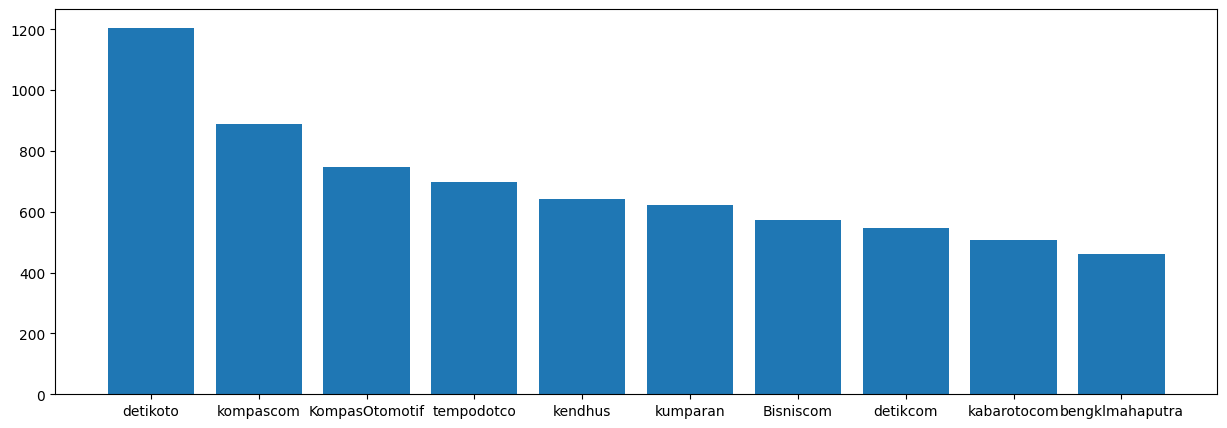

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.bar(top10users['username'], top10users['count'])

## Term Frequency Analysis

In [ ]:
words = df['tokenized']
list_of_words = []
for wordlist in words:
    list_of_words += wordlist
    
print(list_of_words[:20])

['kabar', 'emiten', 'isat', 'raih', 'us', 'juta', 'slis', 'pantik', 'kendara', 'listrik', 'bmw', 'siap', 'alih', 'mobillistrik', 'bmw', 'siap', 'alih', 'mobillistrik', 'bmw', 'siap']


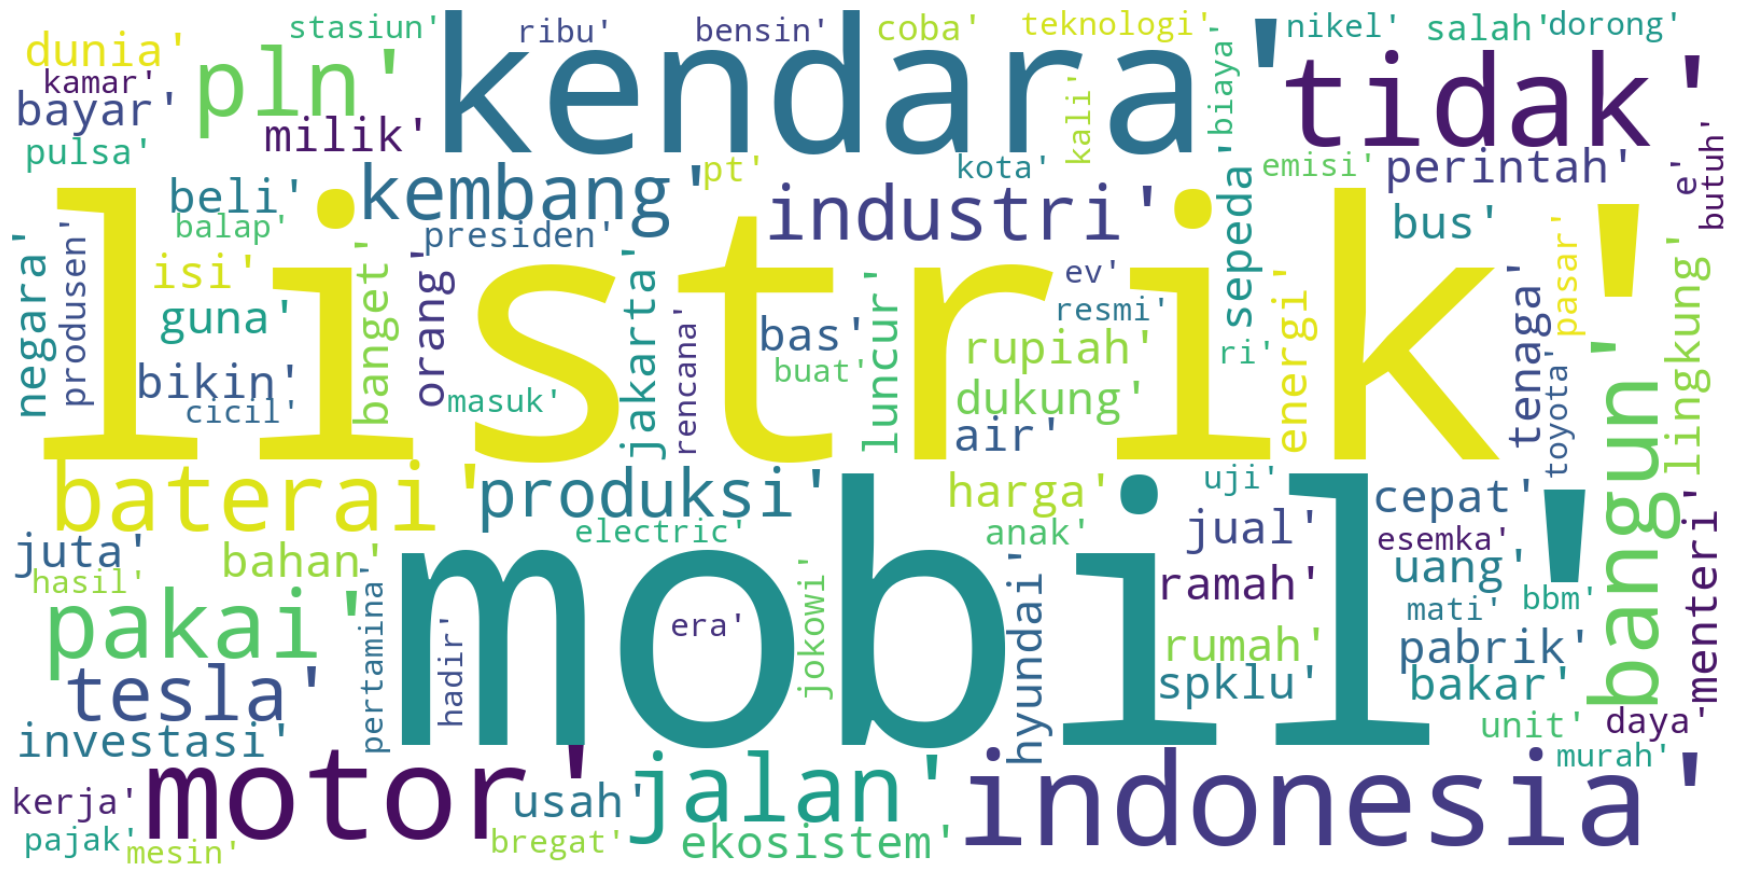

In [ ]:
mostcommon = FreqDist(list_of_words).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
#plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=5)
plt.show()

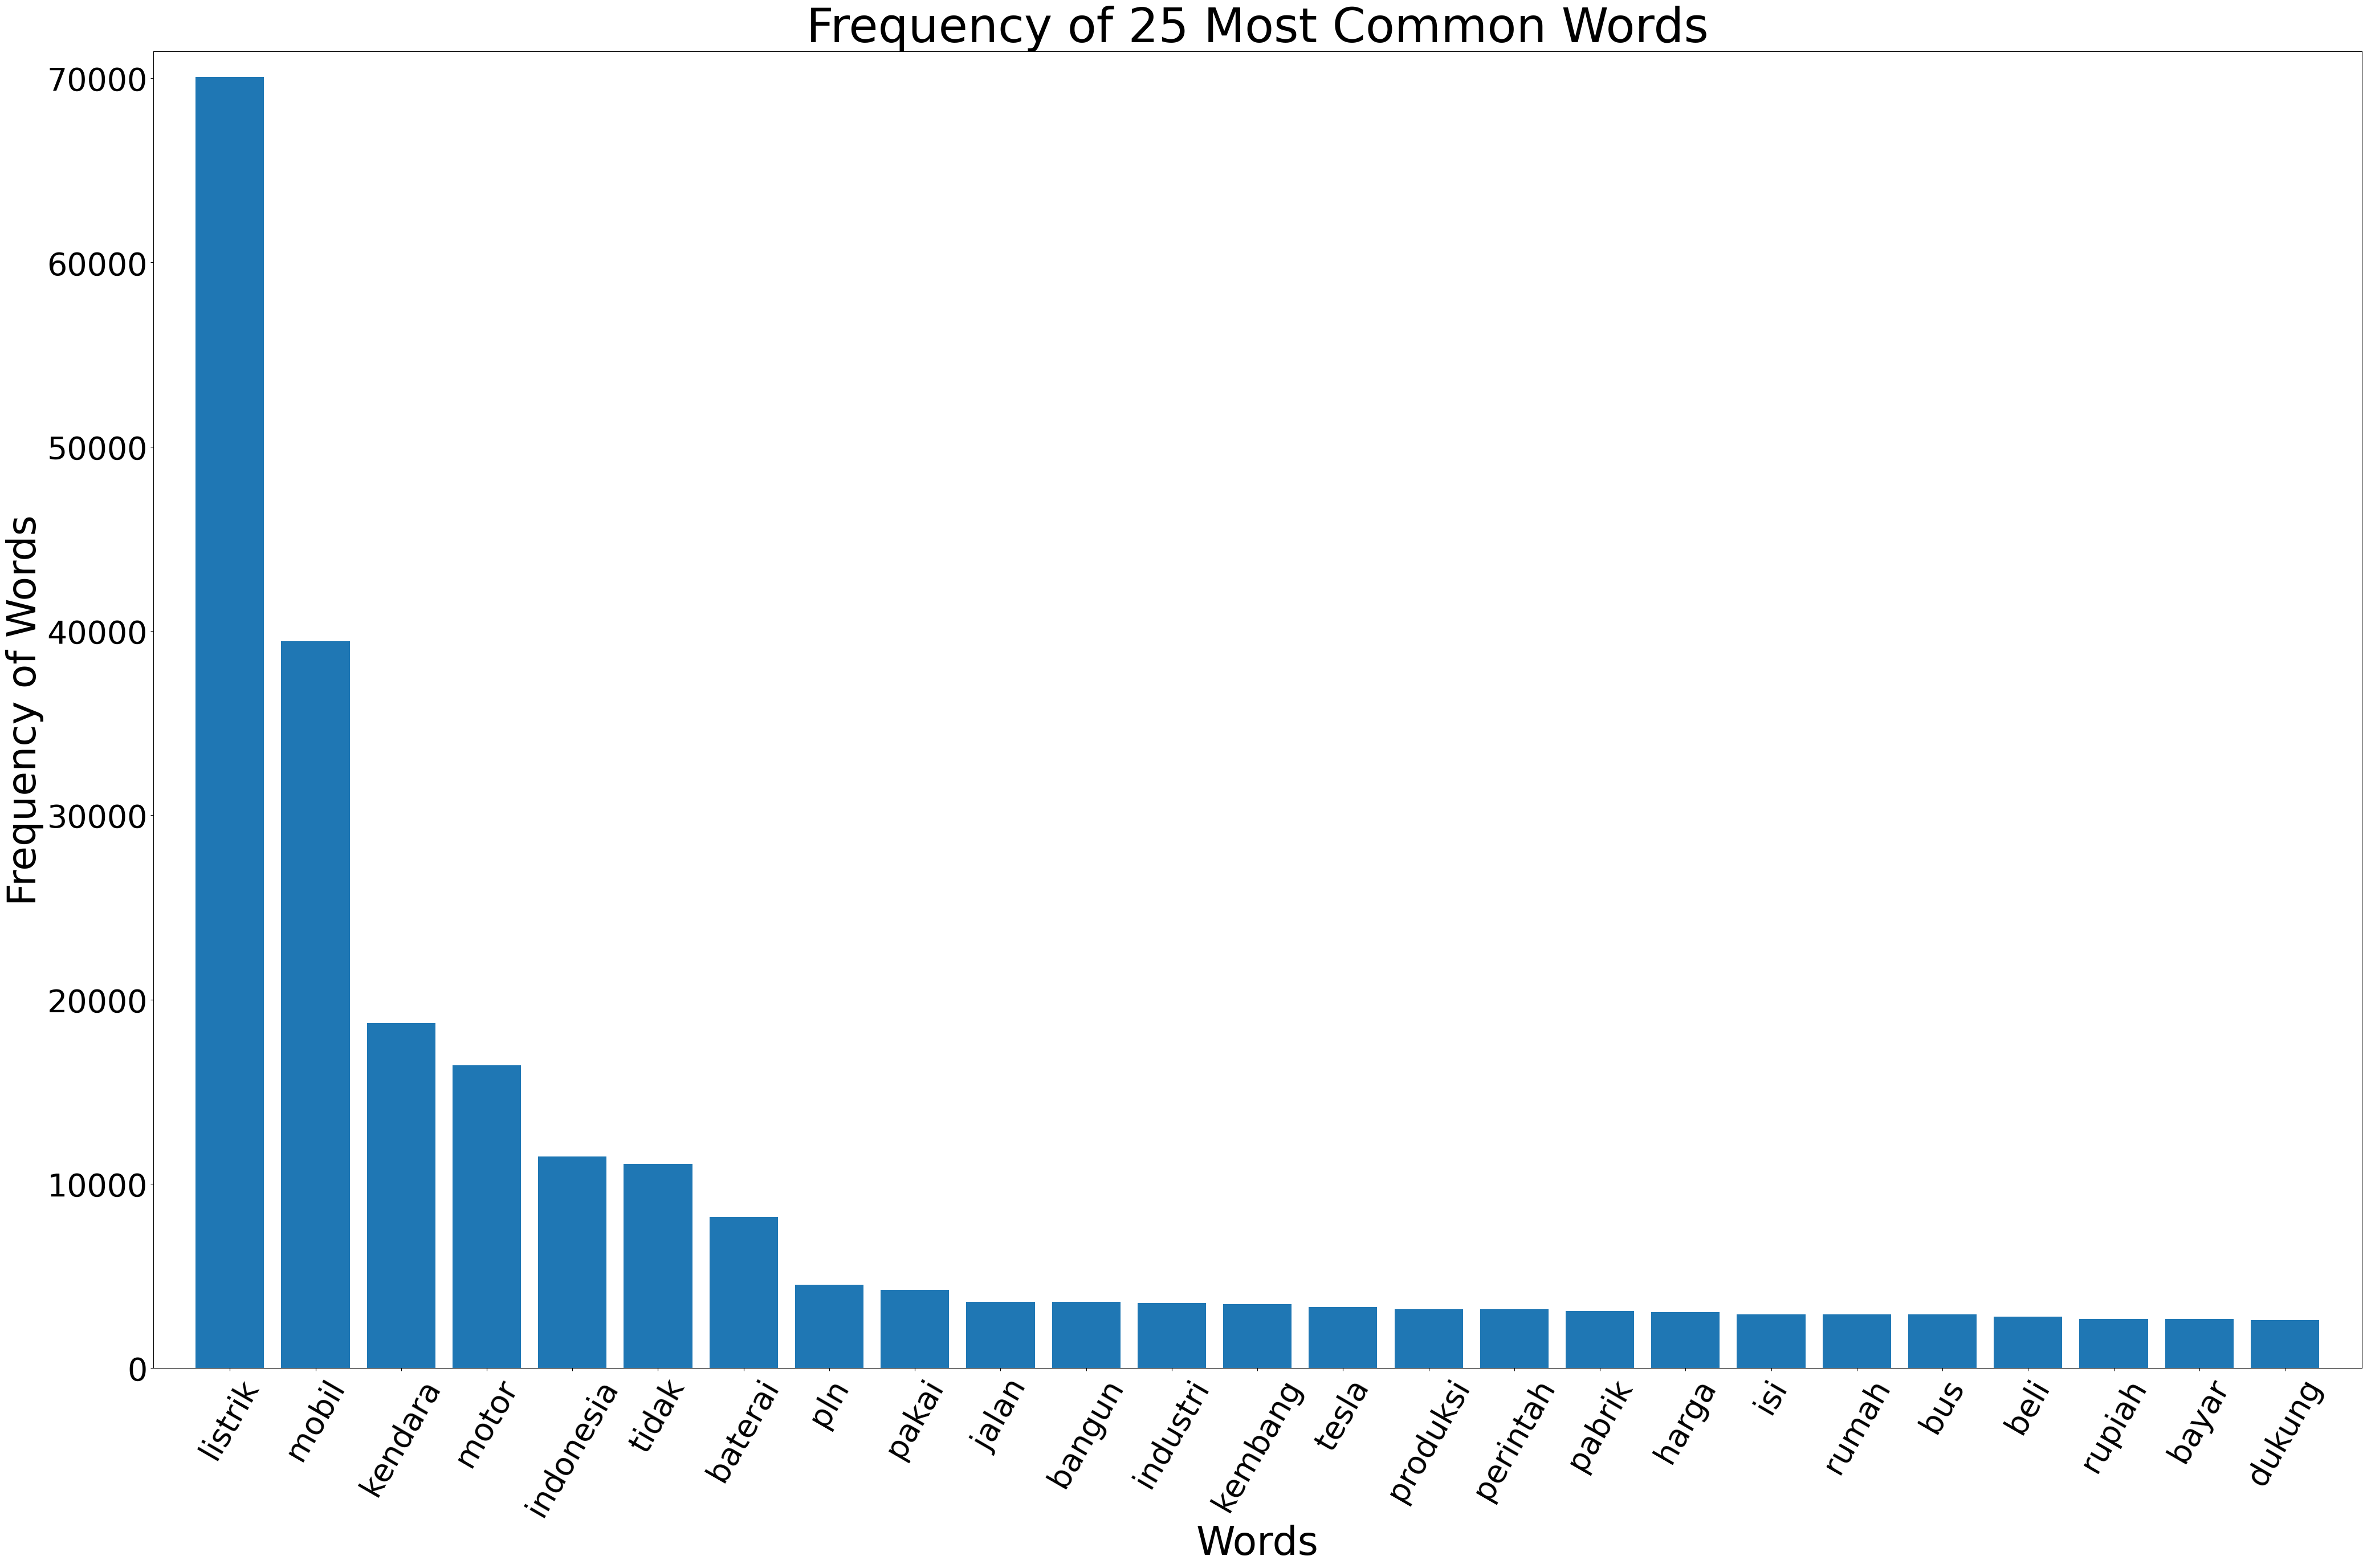

In [ ]:
mostcommon_small = FreqDist(list_of_words).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

## Word Count Distribution

In [ ]:
df['tweet_word_count'] = df['text'].astype('str').str.count(' ')

print(df.tweet_word_count.describe())

count    65347.000000
mean        19.416760
std         11.100147
min          0.000000
25%         10.000000
50%         16.000000
75%         28.000000
max        104.000000
Name: tweet_word_count, dtype: float64


65347 documents in total
1993 documents have fewer than 5 words
3.0% documents have fewer than 5 words


Text(0.5, 0, 'Word Count')

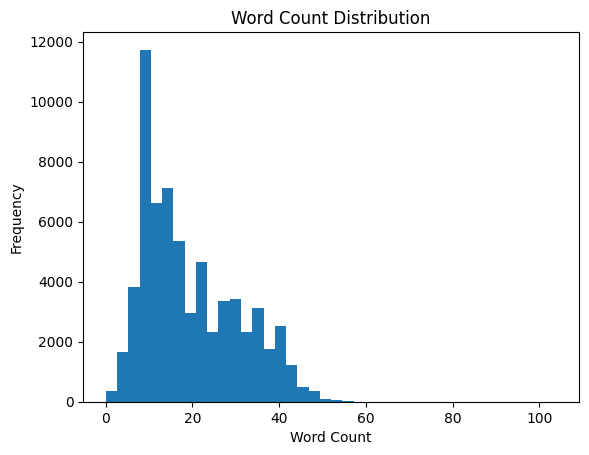

In [ ]:
# word count distribution
N = 5
print('{} documents in total'.format(df.shape[0]))
print('{} documents have fewer than {N} words'.format(df[df.tweet_word_count<=N].shape[0], N = N))
print('{}% documents have fewer than {N} words'.format(round(df[df.tweet_word_count<=N].shape[0]/df.shape[0]*100, 1), N = N))

ax = df.tweet_word_count.plot.hist(bins=40)
ax.set_title("Word Count Distribution")
ax.set_xlabel('Word Count')

# Topic Modeling
---

## LDA Using Gensim

### Tokenize using Gensim

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = list_of_texts
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['kabar', 'emiten', 'isat', 'raih', 'us', 'juta', 'slis', 'pantik', 'kendara', 'listrik']


### Phrase Modeling: Bigram and Trigram Models

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

print(data_words_bigrams[:1][0])

['kabar', 'emiten', 'isat', 'raih', 'us', 'juta', 'slis', 'pantik', 'kendara', 'listrik']


### Data Transformation: Corpus and Dictionary

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


### Base Model

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.069*"listrik" + 0.044*"bayar" + 0.043*"motor" + 0.026*"jalan" + '
  '0.026*"rumah" + 0.025*"cicil" + 0.023*"air" + 0.015*"pulsa" + 0.013*"tanah" '
  '+ 0.012*"pulsa_hp"'),
 (1,
  '0.090*"listrik" + 0.076*"tidak" + 0.058*"mobil" + 0.043*"motor" + '
  '0.027*"pakai" + 0.023*"beli" + 0.015*"orang" + 0.012*"banget" + '
  '0.011*"rumah" + 0.009*"jalan"'),
 (2,
  '0.046*"formula" + 0.039*"balap" + 0.034*"mobil" + 0.028*"listrik" + '
  '0.025*"jakarta" + 0.013*"bahan_baku" + 0.011*"bantu" + 0.009*"ajang_balap" '
  '+ 0.009*"hitung" + 0.007*"putus"'),
 (3,
  '0.077*"mobil" + 0.074*"listrik" + 0.059*"harga" + 0.041*"rupiah" + '
  '0.038*"juta" + 0.036*"jual" + 0.029*"murah" + 0.028*"unit" + 0.022*"ribu" + '
  '0.012*"capai"'),
 (4,
  '0.109*"listrik" + 0.060*"pln" + 0.049*"kendara" + 0.040*"isi" + '
  '0.032*"motor" + 0.023*"spklu" + 0.019*"stasiun" + 0.016*"daya" + '
  '0.015*"mobil" + 0.014*"keren"'),
 (5,
  '0.100*"listrik" + 0.054*"kendara" + 0.048*"mobil" + 0.017*"tidak" + '
  '0

### Compute Model Perplexity and Coherence Score

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.40524930628717504


### Hyperparameter Tuning

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [7:01:11<00:00, 46.80s/it]  


In [ ]:
lda_tuning = pd.read_csv('lda_tuning_results.csv')

In [ ]:
lda_tuning.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.248114
1,75% Corpus,2,0.01,0.31,0.254730
2,75% Corpus,2,0.01,0.61,0.256894
3,75% Corpus,2,0.01,0.9099999999999999,0.264235
4,75% Corpus,2,0.01,symmetric,0.254730


In [ ]:
lda_tuning['Alpha'].unique()

array(['0.01', '0.31', '0.61', '0.9099999999999999', 'symmetric',
       'asymmetric'], dtype=object)

In [ ]:
lda_tuning['Beta'].unique()

array(['0.01', '0.31', '0.61', '0.9099999999999999', 'symmetric'],
      dtype=object)

In [ ]:
lda_default = lda_tuning.loc[(lda_tuning['Alpha']=='symmetric') & (lda_tuning['Beta']=='0.01') & (lda_tuning['Validation_Set']=='100% Corpus')].reset_index(drop=True)

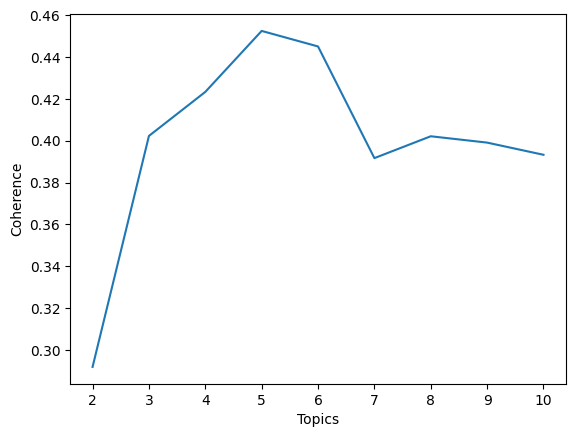

In [ ]:
sns.lineplot(x = "Topics", y = "Coherence", data=lda_default)
plt.show()

In [ ]:
lda_topic_5 = lda_tuning.loc[(lda_tuning['Validation_Set'] == '100% Corpus' ) & (lda_tuning['Topics'] == 5)].reset_index(drop=True)

In [ ]:
lda_topic_5.sort_values(by='Coherence', ascending=False).head()

,Validation_Set,Topics,Alpha,Beta,Coherence
17,100% Corpus,5,0.9099999999999999,0.61,0.500878
18,100% Corpus,5,0.9099999999999999,0.9099999999999999,0.496297
10,100% Corpus,5,0.61,0.01,0.491973
12,100% Corpus,5,0.61,0.61,0.490276
13,100% Corpus,5,0.61,0.9099999999999999,0.488792


### Final Result

In [ ]:
num_topics = 5

lda_best_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.9,
                                           eta=0.6)

In [ ]:
# Compute Coherence Score
coherence_best_model_lda = CoherenceModel(model=lda_best_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_best_lda = coherence_best_model_lda.get_coherence()
print('Coherence Score: ', coherence_best_lda)

Coherence Score:  0.49295522640674505


In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_best_model.print_topics())
doc_lda = lda_best_model[corpus]

[(0,
  '0.054*"listrik" + 0.031*"motor" + 0.024*"tidak" + 0.021*"jalan" + '
  '0.017*"beli" + 0.017*"rumah" + 0.016*"bayar" + 0.010*"air" + 0.009*"banget" '
  '+ 0.008*"cicil"'),
 (1,
  '0.086*"listrik" + 0.066*"motor" + 0.017*"pakai" + 0.016*"bus" + '
  '0.014*"tidak" + 0.014*"sepeda" + 0.011*"jakarta" + 0.010*"bakar" + '
  '0.009*"formula" + 0.009*"ramah_lingkung"'),
 (2,
  '0.074*"mobil" + 0.058*"listrik" + 0.028*"tidak" + 0.026*"indonesia" + '
  '0.020*"produksi" + 0.012*"dunia" + 0.012*"bikin" + 0.010*"pabrik" + '
  '0.010*"negara" + 0.009*"tesla"'),
 (3,
  '0.154*"mobil" + 0.116*"listrik" + 0.014*"harga" + 0.013*"jual" + '
  '0.012*"rupiah" + 0.009*"hyundai" + 0.009*"luncur" + 0.008*"wuling" + '
  '0.007*"murah" + 0.007*"unit"'),
 (4,
  '0.098*"kendara" + 0.092*"listrik" + 0.034*"baterai" + 0.034*"indonesia" + '
  '0.025*"pln" + 0.018*"kembang" + 0.017*"industri" + 0.016*"perintah" + '
  '0.015*"bangun" + 0.014*"isi"')]


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_best_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.280091  0.093734       1        1  21.311967
0      0.201148  0.103452       2        1  20.858128
2     -0.002957 -0.143144       3        1  20.448964
1      0.061234  0.151314       4        1  19.030281
3      0.020666 -0.205356       5        1  18.350660, topic_info=           Term          Freq         Total Category  logprob  loglift
16        mobil  34672.000000  34672.000000  Default  30.0000  30.0000
4       kendara  16209.000000  16209.000000  Default  29.0000  29.0000
68        motor  15246.000000  15246.000000  Default  28.0000  28.0000
215     baterai   6408.000000   6408.000000  Default  27.0000  27.0000
32    indonesia  10088.000000  10088.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
179       resmi    572.974666   1045.770540   Topic5  -5.5075   1.0938
51        tesla    688.835763   2064.115131   Topic5  -5.3233   0.5981
1284       ribu    506.900397    876.116666   Topic5  -5.6300   1.1483
699        baru    476.637588    767.153828   Topic5  -5.6915   1.2196
32    indonesia    480.197650  10088.136504   Topic5  -5.6841  -1.3494

[292 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1096      1  0.002733  acara
1096      2  0.002733  acara
1096      3  0.002733  acara
1096      4  0.992013  acara
1096      5  0.002733  acara
...     ...       ...    ...
321       1  0.007145    yuk
321       2  0.008574    yuk
321       3  0.001429    yuk
321       4  0.161473    yuk
321       5  0.821653    yuk

[1205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 2, 4])

## BERTopic

### Testing